In [1]:
import os
import shutil

for folder in ["datasets", "simulator", "mbrl", "experiments"]:
    if os.path.exists(folder):
        shutil.rmtree(folder)
    os.makedirs(folder, exist_ok=True)

print("Project folders created:")
print(os.listdir())


Project folders created:
['datasets', 'simulator', 'experiments', 'mbrl', '.virtual_documents']


In [2]:
%%writefile simulator/cache_simulator.py
import collections
import numpy as np

class SharedCacheSimulator:
    """
    Shared-cache simulator with full metrics
    for LRU + dynamic allocation + MBRL.
    """

    def __init__(self, total_capacity, tenant_ids):
        self.total_capacity = total_capacity
        self.tenant_ids = tenant_ids

        # equal initial partitions
        equal = total_capacity // len(tenant_ids)
        self.partition = {t: equal for t in tenant_ids}

        # LRU caches
        self.cache = {t: collections.OrderedDict() for t in tenant_ids}

        # ---- Metrics required by run_mbrl.py ----
        self.hits = 0
        self.misses = 0
        self.tenant_hits = {t: 0 for t in tenant_ids}
        self.tenant_misses = {t: 0 for t in tenant_ids}

        self.latency_hit = 1.0
        self.latency_miss = 10.0
        self.latency_log = []
        self.total_latency = 0.0

        self.backhaul_traffic = 0
        self.communication_cost = 0
        self.update_rounds = 0
        # ------------------------------------------

    def allocate(self, fractions):
        fractions = np.array(fractions)
        self.communication_cost += len(fractions) * 8
        self.update_rounds += 1

        new_sizes = {
            t: max(1, int(self.total_capacity * f))
            for t, f in zip(self.tenant_ids, fractions)
        }

        self.partition = new_sizes

        # trim LRU if needed
        for t in self.tenant_ids:
            while len(self.cache[t]) > self.partition[t]:
                self.cache[t].popitem(last=False)

    def process_request(self, tenant, content_id):
        c = self.cache[tenant]

        # HIT
        if content_id in c:
            c.move_to_end(content_id)

            self.hits += 1
            self.tenant_hits[tenant] += 1

            self.latency_log.append(self.latency_hit)
            self.total_latency += self.latency_hit

            return True, None

        # MISS
        self.misses += 1
        self.tenant_misses[tenant] += 1

        self.latency_log.append(self.latency_miss)
        self.total_latency += self.latency_miss
        self.backhaul_traffic += 1

        eviction = None
        if len(c) >= self.partition[tenant]:
            eviction, _ = c.popitem(last=False)

        c[content_id] = True

        return False, eviction


Writing simulator/cache_simulator.py


In [3]:
from simulator.cache_simulator import SharedCacheSimulator
print("Simulator now imports correctly!")


Simulator now imports correctly!


In [4]:
import os
import numpy as np
import pandas as pd

os.makedirs("datasets", exist_ok=True)

# ---------------------------------------------------------
# Helper: Write dataset
# ---------------------------------------------------------
def write_trace(path, tenants, contents):
    df = pd.DataFrame({
        "tenant_id": tenants,
        "content_id": contents
    })
    df.to_csv(path, index=False)

# ---------------------------------------------------------
# 1. Zipf Distribution Dataset
# ---------------------------------------------------------
def generate_zipf_trace(N=50000, T=10, C=1000, alpha=1.2):
    print("Generating Zipf dataset...")
    tenants = np.random.randint(0, T, size=N)
    content_probs = np.random.zipf(alpha, C)
    content_probs = content_probs / content_probs.sum()

    contents = np.random.choice(np.arange(C), size=N, p=content_probs)
    write_trace("datasets/zipf_trace.csv", tenants, contents)

# ---------------------------------------------------------
# 2. Drift Dataset
# ---------------------------------------------------------
def generate_drift_trace(N=50000, T=10, C=1000):
    print("Generating Drift dataset...")
    tenants = np.random.randint(0, T, size=N)

    contents = []
    current_pop = np.random.dirichlet(np.ones(C))

    for i in range(N):
        if i % 5000 == 0 and i != 0:
            # small drift every 5k
            current_pop = 0.8 * current_pop + 0.2 * np.random.dirichlet(np.ones(C))
            current_pop /= current_pop.sum()
        contents.append(np.random.choice(np.arange(C), p=current_pop))

    write_trace("datasets/drift_trace.csv", tenants, contents)

# ---------------------------------------------------------
# 3. Imbalanced Tenant Load (some tenants heavy)
# ---------------------------------------------------------
def generate_imbalanced_tenant_trace(N=50000, T=10, C=1000):
    print("Generating imbalanced tenant dataset...")
    tenant_probs = np.array([5 if i < 2 else 1 for i in range(T)])
    tenant_probs = tenant_probs / tenant_probs.sum()

    tenants = np.random.choice(np.arange(T), size=N, p=tenant_probs)
    contents = np.random.randint(0, C, size=N)

    write_trace("datasets/imbalanced_tenant_trace.csv", tenants, contents)

# ---------------------------------------------------------
# 4. Balanced Catalog Use (all contents equal)
# ---------------------------------------------------------
def generate_balanced_catalog_trace(N=50000, T=10, C=1000):
    print("Generating balanced catalog dataset...")
    tenants = np.random.randint(0, T, size=N)
    contents = np.random.randint(0, C, size=N)
    write_trace("datasets/balanced_catalog_trace.csv", tenants, contents)

# ---------------------------------------------------------
# 5. Imbalanced Catalog Use (few contents hot)
# ---------------------------------------------------------
def generate_imbalanced_catalog_trace(N=50000, T=10, C=1000):
    print("Generating imbalanced catalog dataset...")
    tenants = np.random.randint(0, T, size=N)

    # 50 super-hot contents
    hot = 50
    hot_prob = 0.9
    rest_prob = 0.1

    probs = np.array(
        [hot_prob / hot] * hot +
        [rest_prob / (C - hot)] * (C - hot)
    )

    contents = np.random.choice(np.arange(C), size=N, p=probs)
    write_trace("datasets/imbalanced_catalog_trace.csv", tenants, contents)

# ---------------------------------------------------------
# Generate all datasets
# ---------------------------------------------------------
def generate_all():
    generate_zipf_trace()
    generate_drift_trace()
    generate_imbalanced_tenant_trace()
    generate_balanced_catalog_trace()
    generate_imbalanced_catalog_trace()
    print("All datasets created successfully")

if __name__ == "__main__":
    generate_all()


Generating Zipf dataset...
Generating Drift dataset...
Generating imbalanced tenant dataset...
Generating balanced catalog dataset...
Generating imbalanced catalog dataset...
All datasets created successfully


In [5]:
# Recreate generator, run it, and list dataset files + show heads
import os, subprocess, sys, textwrap, pandas as pd

code = textwrap.dedent("""
import os
import numpy as np
import pandas as pd

os.makedirs("datasets", exist_ok=True)

def write_trace(path, tenants, contents):
    df = pd.DataFrame({
        "tenant_id": tenants,
        "content_id": contents
    })
    df.to_csv(path, index=False)

def generate_zipf_trace(N=50000, T=10, C=1000, alpha=1.2, seed=0):
    np.random.seed(seed)
    tenants = np.random.randint(0, T, size=N)
    # use Zipf-like by sampling ranks and converting to probabilities
    ranks = np.arange(1, C+1)
    pop = ranks ** (-alpha)
    pop = pop / pop.sum()
    contents = np.random.choice(np.arange(C), size=N, p=pop)
    write_trace("datasets/zipf_trace.csv", tenants, contents)
    print("zipf done")

def generate_drift_trace(N=50000, T=10, C=1000, seed=1):
    np.random.seed(seed)
    tenants = np.random.randint(0, T, size=N)
    contents = []
    # start with a base Zipf-like
    ranks = np.arange(1, C+1)
    base = ranks ** (-1.2)
    base = base / base.sum()
    current_pop = base.copy()
    for i in range(N):
        if i % 5000 == 0 and i != 0:
            # small drift
            noise = np.random.normal(0, 0.2, size=C)
            p = np.clip(base + noise, 1e-12, None)
            p = p / p.sum()
            current_pop = p
        contents.append(np.random.choice(np.arange(C), p=current_pop))
    write_trace("datasets/drift_trace.csv", tenants, contents)
    print("drift done")

def generate_imbalanced_tenant_trace(N=50000, T=10, C=1000, seed=2):
    np.random.seed(seed)
    tenant_probs = np.array([5 if i < 2 else 1 for i in range(T)], dtype=float)
    tenant_probs /= tenant_probs.sum()
    tenants = np.random.choice(np.arange(T), size=N, p=tenant_probs)
    contents = np.random.randint(0, C, size=N)
    write_trace("datasets/imbalanced_tenant_trace.csv", tenants, contents)
    print("imbalanced_tenant done")

def generate_balanced_catalog_trace(N=50000, T=10, total_items=1000, seed=3):
    np.random.seed(seed)
    items_per = total_items // T
    offsets = [i*items_per for i in range(T)]
    tenants = np.random.randint(0, T, size=N)
    contents = []
    for _ in range(N):
        t = np.random.randint(0, T)
        local = np.random.randint(0, items_per)
        contents.append(offsets[t] + local)
    write_trace("datasets/balanced_catalog_trace.csv", tenants, contents)
    print("balanced_catalog done")

def generate_imbalanced_catalog_trace(N=50000, T=10, total_items=1000, seed=4):
    np.random.seed(seed)
    heavy = [400, 300]
    small = (total_items - sum(heavy)) // (T - len(heavy))
    sizes = heavy + [small]*(T - len(heavy))
    # adjust last
    diff = total_items - sum(sizes)
    sizes[-1] += diff
    offsets = []
    cur = 0
    for s in sizes:
        offsets.append(cur)
        cur += s
    # tenant probs skewed to heavy
    tenant_probs = np.array([0.30, 0.25] + [(1 - 0.55)/(T - 2)]*(T - 2))
    tenant_probs /= tenant_probs.sum()
    tenants = np.random.choice(np.arange(T), size=N, p=tenant_probs)
    contents = []
    for t in tenants:
        s = sizes[t]
        # Zipf within tenant catalog
        ranks = np.arange(1, s+1)
        p = ranks ** (-1.2)
        p /= p.sum()
        local = np.random.choice(np.arange(s), p=p)
        contents.append(offsets[t] + local)
    write_trace("datasets/imbalanced_catalog_trace.csv", tenants, contents)
    print("imbalanced_catalog done")

if __name__ == "__main__":
    generate_zipf_trace()
    generate_drift_trace()
    generate_imbalanced_tenant_trace()
    generate_balanced_catalog_trace()
    generate_imbalanced_catalog_trace()
    print("All datasets written to datasets/")
""")

# Write generator file
with open("datasets/generate_datasets.py", "w") as f:
    f.write(code)

# Run the generator script
print("Running generator...")
ret = os.system(sys.executable + " datasets/generate_datasets.py")
print("Generator exit code:", ret)
print()

# List files and show heads
files = sorted([f for f in os.listdir("datasets") if f.endswith(".csv")])
print("Dataset CSV files:", files)
print()
for f in files:
    print("----", f, "----")
    df = pd.read_csv(os.path.join("datasets", f))
    print(df.head(6).to_string(index=False))
    print("Total rows:", len(df))
    print()


Running generator...
zipf done
drift done
imbalanced_tenant done
balanced_catalog done
imbalanced_catalog done
All datasets written to datasets/
Generator exit code: 0

Dataset CSV files: ['balanced_catalog_trace.csv', 'drift_trace.csv', 'imbalanced_catalog_trace.csv', 'imbalanced_tenant_trace.csv', 'zipf_trace.csv']

---- balanced_catalog_trace.csv ----
 tenant_id  content_id
         8         347
         9         576
         3         883
         8         861
         8         360
         0         245
Total rows: 50000

---- drift_trace.csv ----
 tenant_id  content_id
         5           1
         8           8
         9          46
         5           8
         0          17
         0          14
Total rows: 50000

---- imbalanced_catalog_trace.csv ----
 tenant_id  content_id
         9         962
         1         494
         9         964
         4         774
         4         774
         0          34
Total rows: 50000

---- imbalanced_tenant_trace.csv ----


In [6]:
# Run LRU equal-split baseline on all datasets (uses simulator/cache_simulator.py)
import os, sys
import numpy as np
import pandas as pd

# ensure simulator package is importable
ROOT = "/kaggle/working"
if ROOT not in sys.path:
    sys.path.append(ROOT)

from simulator.cache_simulator import SharedCacheSimulator

DATA_DIR = "datasets"
OUT_DIR = "results"
os.makedirs(OUT_DIR, exist_ok=True)

files = sorted([f for f in os.listdir(DATA_DIR) if f.endswith(".csv")])
summary_rows = []

for fname in files:
    path = os.path.join(DATA_DIR, fname)
    df = pd.read_csv(path)
    trace = list(zip(df["tenant_id"].astype(int).values, df["content_id"].astype(int).values))
    tenants = sorted(df["tenant_id"].unique().tolist())
    K = len(tenants)

    sim = SharedCacheSimulator(total_capacity=1000, tenant_ids=tenants)  # total cache 1000
    sim.allocate(np.ones(K) / K)  # equal split

    hits = 0
    per_t_hits = {t: 0 for t in tenants}
    per_t_reqs = {t: 0 for t in tenants}

    for (t, c) in trace:
        hit, _ = sim.process_request(int(t), int(c))
        per_t_reqs[int(t)] += 1
        if hit:
            hits += 1
            per_t_hits[int(t)] += 1

    overall_hr = hits / len(trace)
    # per-tenant hit rates for first 8 tenants (or all if <8)
    tenants_display = tenants[:8]
    per_t_summary = {t: (per_t_hits[t] / per_t_reqs[t]) if per_t_reqs[t]>0 else None for t in tenants_display}

    print(f"=== {fname} ===")
    print(f"Total requests: {len(trace):,}, Tenants: {K}, Cache=1000 (equal-split)")
    print(f"LRU equal-split overall hit rate: {overall_hr:.4f}")
    print("Per-tenant hit rates (first up to 8 tenants):")
    for t in tenants_display:
        print(f"  tenant {t}: requests={per_t_reqs[t]:,}, hit_rate={per_t_summary[t]:.4f}")
    print()

    summary_rows.append([fname, len(trace), K, overall_hr])

# save summary
pd.DataFrame(summary_rows, columns=["dataset","n_requests","n_tenants","lru_hit_rate"]).to_csv(os.path.join(OUT_DIR,"lru_summary.csv"), index=False)
print("Saved results/lru_summary.csv")


=== balanced_catalog_trace.csv ===
Total requests: 50,000, Tenants: 10, Cache=1000 (equal-split)
LRU equal-split overall hit rate: 0.0994
Per-tenant hit rates (first up to 8 tenants):
  tenant 0: requests=4,943, hit_rate=0.1048
  tenant 1: requests=5,055, hit_rate=0.0977
  tenant 2: requests=4,943, hit_rate=0.0951
  tenant 3: requests=5,052, hit_rate=0.0972
  tenant 4: requests=4,997, hit_rate=0.0989
  tenant 5: requests=5,036, hit_rate=0.1054
  tenant 6: requests=4,949, hit_rate=0.0956
  tenant 7: requests=4,909, hit_rate=0.1031

=== drift_trace.csv ===
Total requests: 50,000, Tenants: 10, Cache=1000 (equal-split)
LRU equal-split overall hit rate: 0.3177
Per-tenant hit rates (first up to 8 tenants):
  tenant 0: requests=4,982, hit_rate=0.3151
  tenant 1: requests=4,930, hit_rate=0.3189
  tenant 2: requests=4,943, hit_rate=0.3073
  tenant 3: requests=4,982, hit_rate=0.3185
  tenant 4: requests=4,954, hit_rate=0.3145
  tenant 5: requests=5,130, hit_rate=0.3140
  tenant 6: requests=5,063

In [7]:
%%writefile mbrl/online_mbrl_agent.py
import numpy as np
from collections import defaultdict, deque

class OnlineMBRLAgent:
    """
    Simple online MBRL agent for dynamic cache allocation.
    Predicts future tenant demand using an exponential moving average (EMA)
    and redistributes cache capacity accordingly every update_interval steps.
    """

    def __init__(self, tenant_ids, total_capacity=1000, update_interval=1000, ema_alpha=0.1):
        self.tenant_ids = tenant_ids
        self.K = len(tenant_ids)
        self.total_capacity = total_capacity
        self.update_interval = update_interval
        self.ema_alpha = ema_alpha

        # demand model: predicted request probability for each tenant
        self.pred_demand = {t: 1.0 / self.K for t in tenant_ids}

        # counters for the current interval
        self.interval_counts = {t: 0 for t in tenant_ids}
        self.steps = 0

    def observe(self, tenant_id):
        """Record each request for online learning."""
        self.interval_counts[tenant_id] += 1
        self.steps += 1

    def update_model(self):
        """Update EMA demand predictions and recompute optimal capacity allocation."""
        total = sum(self.interval_counts.values())
        if total == 0:
            return np.ones(self.K) / self.K  # fallback equal-split

        # compute interval demand proportions
        interval_demand = {t: self.interval_counts[t] / total for t in self.tenant_ids}

        # EMA update
        for t in self.tenant_ids:
            self.pred_demand[t] = (
                self.ema_alpha * interval_demand[t]
                + (1 - self.ema_alpha) * self.pred_demand[t]
            )

        # reset interval counts
        self.interval_counts = {t: 0 for t in self.tenant_ids}

        # convert demand into allocation
        demand_vec = np.array([self.pred_demand[t] for t in self.tenant_ids])
        demand_vec /= demand_vec.sum()  # normalize

        return demand_vec

    def ready_to_update(self):
        """Check if it's time for a reallocation."""
        return self.steps % self.update_interval == 0


Writing mbrl/online_mbrl_agent.py


In [8]:
%%writefile experiments/run_mbrl.py
import os
import sys
import time
import pandas as pd
import numpy as np

# Ensure working dir is importable
ROOT = "/kaggle/working"
if ROOT not in sys.path:
    sys.path.append(ROOT)

from simulator.cache_simulator import SharedCacheSimulator
from mbrl.online_mbrl_agent import OnlineMBRLAgent

DATA_DIR = "datasets"
RESULT_DIR = "results"
os.makedirs(RESULT_DIR, exist_ok=True)


def run_mbrl_on_dataset(csv_path):
    df = pd.read_csv(csv_path)
    tenant_ids = sorted(df["tenant_id"].unique().tolist())
    K = len(tenant_ids)

    sim = SharedCacheSimulator(total_capacity=1000, tenant_ids=tenant_ids)
    sim.allocate(np.ones(K) / K)

    agent = OnlineMBRLAgent(
        tenant_ids,
        total_capacity=1000,
        update_interval=2000,
        ema_alpha=0.1
    )

    total = len(df)
    hits = 0

    start_time = time.time()

    # iterate rows
    for i, row in enumerate(df.itertuples(index=False)):
        t = int(row.tenant_id)
        c = int(row.content_id)

        agent.observe(t)

        if agent.ready_to_update():
            alloc = agent.update_model()
            sim.allocate(alloc)

        hit, _ = sim.process_request(t, c)
        if hit:
            hits += 1

        if (i + 1) % 10000 == 0:
            print(f"MBRL processed {i+1}/{total}")

    end_time = time.time()
    training_time = end_time - start_time

    # Collect metrics
    metrics = {
        "hit_rate": hits / total,
        "global_hits": sim.hits,
        "global_misses": sim.misses,
        "tenant_hits": sim.tenant_hits,
        "tenant_misses": sim.tenant_misses,
        "latency_mean": np.mean(sim.latency_log),
        "latency_p95": np.percentile(sim.latency_log, 95),
        "backhaul_traffic": sim.backhaul_traffic,
        "communication_cost_MB": sim.communication_cost / 1e6,
        "update_rounds": sim.update_rounds,
        "training_time_sec": training_time
    }

    return metrics


if __name__ == "__main__":
    datasets = [
        "zipf_trace.csv",
        "drift_trace.csv",
        "imbalanced_tenant_trace.csv",
        "balanced_catalog_trace.csv",
        "imbalanced_catalog_trace.csv",
    ]

    print("Starting MBRL evaluation (this may take a few minutes)...")

    with open(os.path.join(RESULT_DIR, "mbrl_results.txt"), "w") as f:
        for name in datasets:
            print(f"\nRunning dataset: {name}")
            f.write(f"===== DATASET: {name} =====\n")

            path = os.path.join(DATA_DIR, name)
            m = run_mbrl_on_dataset(path)

            # Print & save metrics
            for k, v in m.items():
                print(f"{k}: {v}")
                f.write(f"{k}: {v}\n")

            f.write("\n")

    print("\nEvaluation complete. Results saved to results/mbrl_results.txt")


Writing experiments/run_mbrl.py


In [9]:
!python experiments/run_mbrl.py


Starting MBRL evaluation (this may take a few minutes)...

Running dataset: zipf_trace.csv
MBRL processed 10000/50000
MBRL processed 20000/50000
MBRL processed 30000/50000
MBRL processed 40000/50000
MBRL processed 50000/50000
hit_rate: 0.75
global_hits: 37500
global_misses: 12500
tenant_hits: {0: 3785, 1: 3748, 2: 3763, 3: 3744, 4: 3739, 5: 3838, 6: 3829, 7: 3674, 8: 3707, 9: 3673}
tenant_misses: {0: 1174, 1: 1230, 2: 1248, 3: 1282, 4: 1338, 5: 1258, 6: 1195, 7: 1280, 8: 1238, 9: 1257}
latency_mean: 3.25
latency_p95: 10.0
backhaul_traffic: 12500
communication_cost_MB: 0.00208
update_rounds: 26
training_time_sec: 0.06271886825561523

Running dataset: drift_trace.csv
MBRL processed 10000/50000
MBRL processed 20000/50000
MBRL processed 30000/50000
MBRL processed 40000/50000
MBRL processed 50000/50000
hit_rate: 0.31656
global_hits: 15828
global_misses: 34172
tenant_hits: {0: 1569, 1: 1554, 2: 1505, 3: 1579, 4: 1540, 5: 1629, 6: 1648, 7: 1560, 8: 1621, 9: 1623}
tenant_misses: {0: 3413, 1: 3

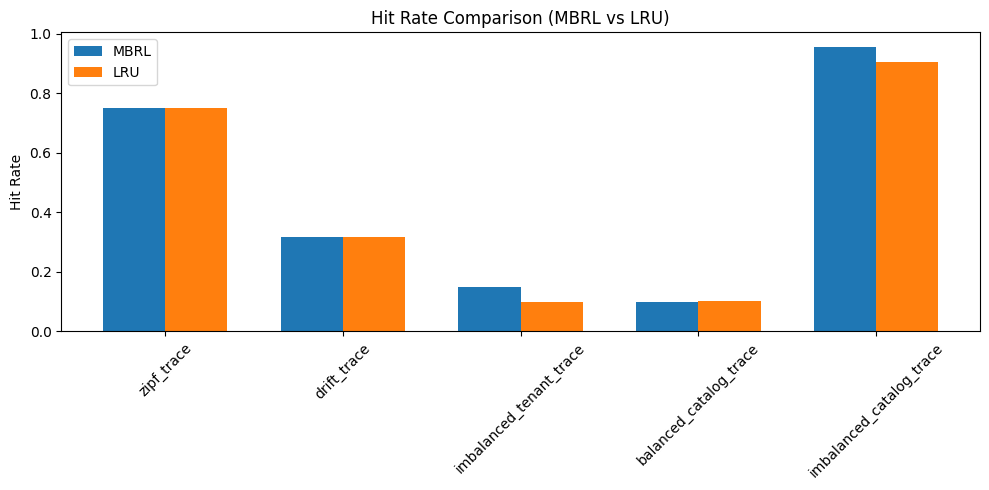

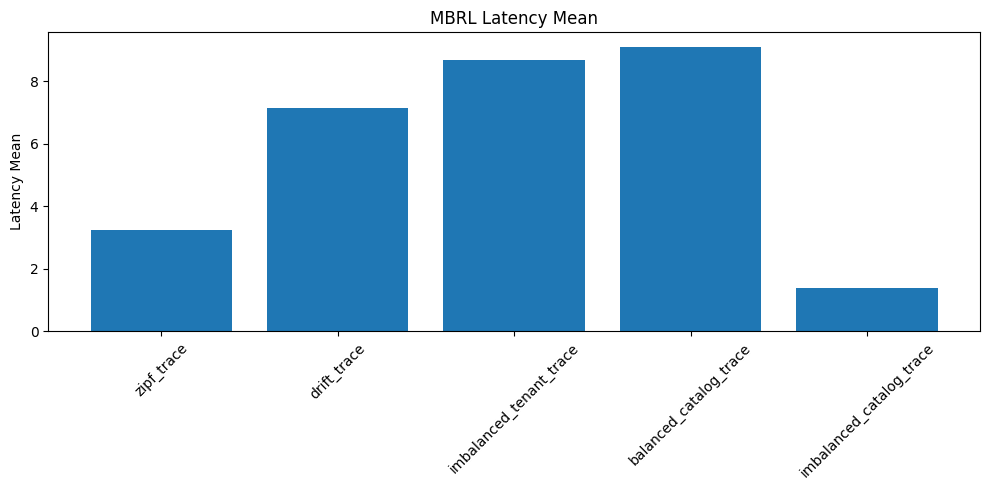

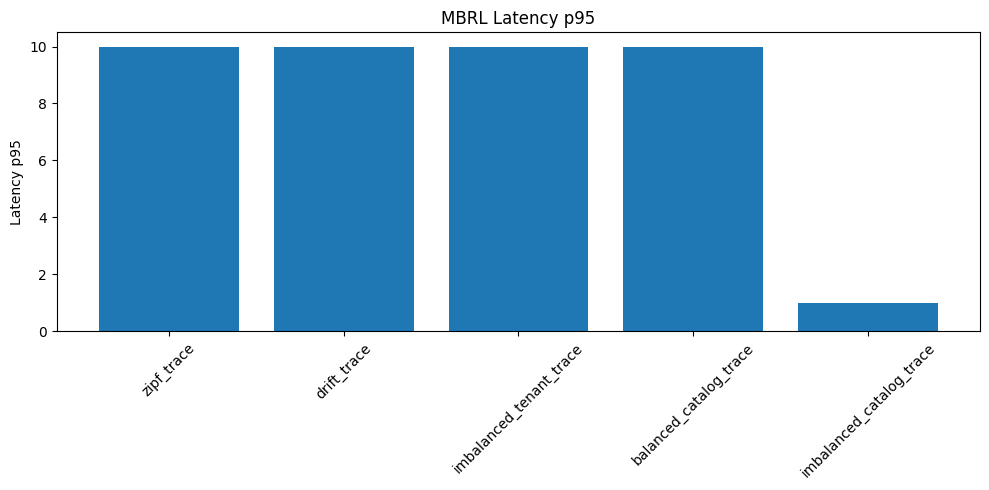

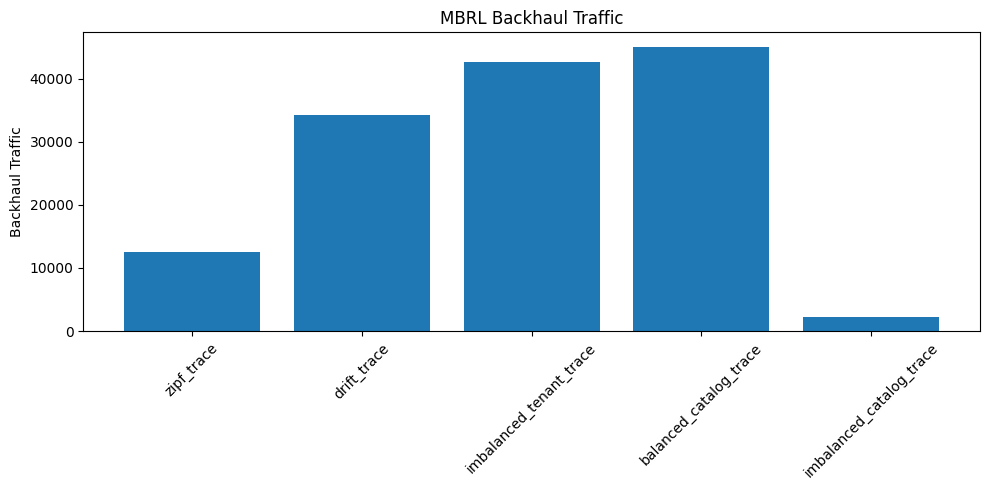

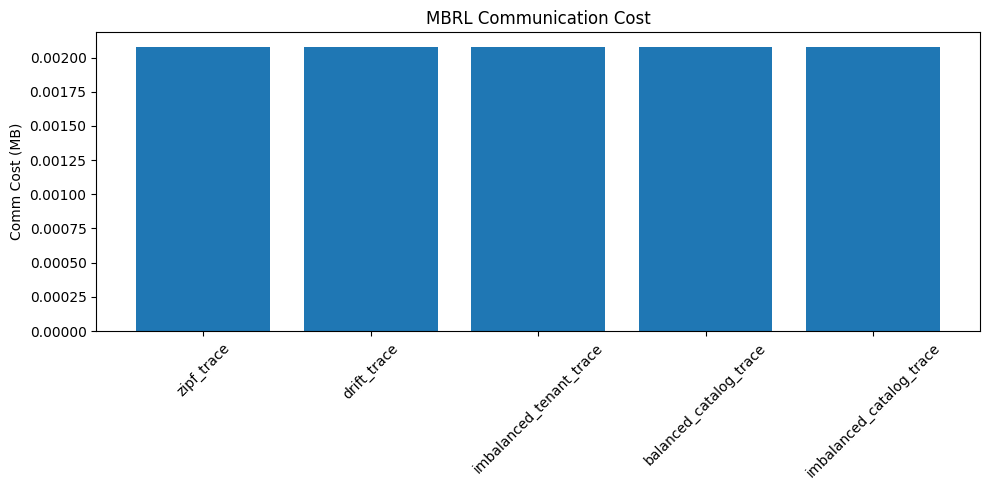

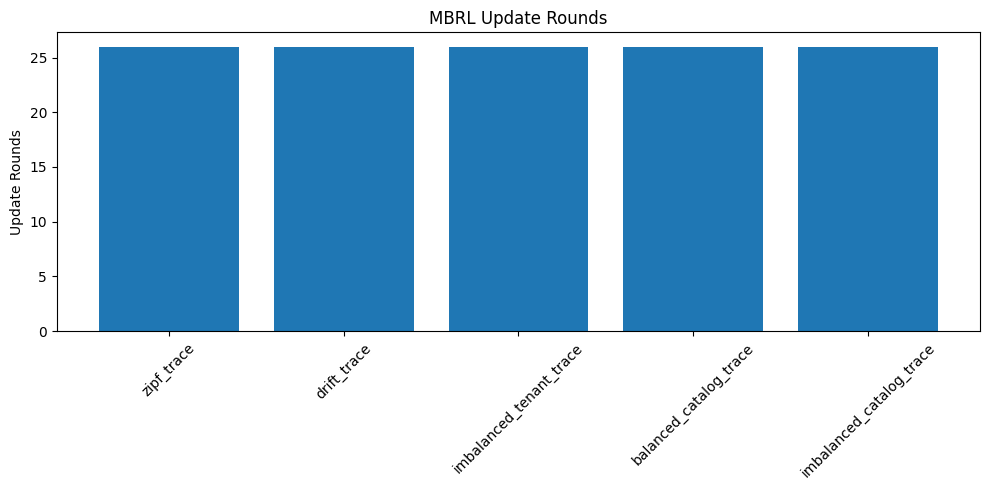

All plots generated 


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

mbrl_data = {
    "dataset": [
        "zipf_trace", "drift_trace", "imbalanced_tenant_trace",
        "balanced_catalog_trace", "imbalanced_catalog_trace"
    ],
    "hit_rate": [0.75, 0.31656, 0.148, 0.09878, 0.95634],
    "latency_mean": [3.25, 7.15096, 8.668, 9.11098, 1.39294],
    "latency_p95": [10, 10, 10, 10, 1],
    "backhaul_traffic": [12500, 34172, 42600, 45061, 2183],
    "communication_cost_MB": [0.00208]*5,
    "update_rounds": [26]*5
}

df_mbrl = pd.DataFrame(mbrl_data)

lru_data = {
    "dataset": [
        "balanced_catalog_trace", "drift_trace",
        "imbalanced_catalog_trace", "imbalanced_tenant_trace",
        "zipf_trace"
    ],
    "hit_rate": [0.0994, 0.3177, 0.9058, 0.0978, 0.7505]
}

df_lru = pd.DataFrame(lru_data)
df_compare = pd.merge(df_mbrl, df_lru, on="dataset", suffixes=("_mbrl", "_lru"))

#  Hit Rate Comparison (MBRL vs LRU)
plt.figure(figsize=(10,5))
x = np.arange(len(df_compare))
width = 0.35
plt.bar(x - width/2, df_compare["hit_rate_mbrl"], width, label="MBRL")
plt.bar(x + width/2, df_compare["hit_rate_lru"], width, label="LRU")
plt.xticks(x, df_compare["dataset"], rotation=45)
plt.ylabel("Hit Rate")
plt.title("Hit Rate Comparison (MBRL vs LRU)")
plt.legend()
plt.tight_layout()
plt.show()

# Latency Mean
plt.figure(figsize=(10,5))
plt.bar(df_mbrl["dataset"], df_mbrl["latency_mean"])
plt.xticks(rotation=45)
plt.ylabel("Latency Mean")
plt.title("MBRL Latency Mean")
plt.tight_layout()
plt.show()

#Latency p95
plt.figure(figsize=(10,5))
plt.bar(df_mbrl["dataset"], df_mbrl["latency_p95"])
plt.xticks(rotation=45)
plt.ylabel("Latency p95")
plt.title("MBRL Latency p95")
plt.tight_layout()
plt.show()

# Backhaul Traffic
plt.figure(figsize=(10,5))
plt.bar(df_mbrl["dataset"], df_mbrl["backhaul_traffic"])
plt.xticks(rotation=45)
plt.ylabel("Backhaul Traffic")
plt.title("MBRL Backhaul Traffic")
plt.tight_layout()
plt.show()

#  Communication Cost
plt.figure(figsize=(10,5))
plt.bar(df_mbrl["dataset"], df_mbrl["communication_cost_MB"])
plt.xticks(rotation=45)
plt.ylabel("Comm Cost (MB)")
plt.title("MBRL Communication Cost")
plt.tight_layout()
plt.show()

#  Update Rounds
plt.figure(figsize=(10,5))
plt.bar(df_mbrl["dataset"], df_mbrl["update_rounds"])
plt.xticks(rotation=45)
plt.ylabel("Update Rounds")
plt.title("MBRL Update Rounds")
plt.tight_layout()
plt.show()

print("All plots generated ")


**FEDERATED LEARNING**

In [11]:
import sys
sys.path.append("/kaggle/working")
sys.path.append("/kaggle/working/federated")
sys.path.append("/kaggle/working/experiments")

print("PYTHONPATH:", sys.path)


PYTHONPATH: ['/kaggle/working', '/kaggle/lib/kagglegym', '/kaggle/lib', '/usr/lib/python311.zip', '/usr/lib/python3.11', '/usr/lib/python3.11/lib-dynload', '', '/usr/local/lib/python3.11/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.11/dist-packages/IPython/extensions', '/root/.ipython', '/kaggle/working', '/kaggle/working/federated', '/kaggle/working/experiments']


In [12]:
import os
os.makedirs("federated", exist_ok=True)
print("Folder created.")


Folder created.


In [13]:
!pip install flwr


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 787.9/787.9 kB 9.9 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 80.0 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 102.0 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.4/242.4 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.1/242.1 kB 16.5 MB/s eta 0:00:00
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.74.0
    Uninstalling grpcio-1.74.0:
      Successfully uninstalled grpcio-1.74.0
  Attempting uninstall: click
    Found existing installation: click 8.3.0
    Uninstalling click-8.3.0:
      Successfully uninstalled click-8.3.0
  Attempting uninstall: rich
    Found existing installation: rich 14.2.0
    Uninstalling rich-14.2.0:
      Successfully uninstalled rich-14.2.0
  Attempting uninstall: cryptography
    Found existin

In [14]:
!pip install --quiet "protobuf==3.20.3"
!pip install --quiet --upgrade "flwr==1.7.0"


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 3.5 MB/s eta 0:00:00a 0:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
grpcio-health-checking 1.76.0 requires protobuf<7.0.0,>=6.31.1, but you have protobuf 3.20.3 which is incompatible.
flwr 1.24.0 requires protobuf<7.0.0,>=5.28.0, but you have protobuf 3.20.3 which is incompatible.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
onnx 1.18.0 requires protobuf>=4.25.1, but you have protobuf 3.20.3 which is incompatible.
a2a-sdk 0.3.10 requires protobuf>=5.29.5, but you have protobuf 3.20.3 which is incompatible.
tensorflow-metadata 1.17.2 requires protobuf>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.
p

In [15]:
import flwr as fl
import numpy as np

class CacheClient(fl.client.NumPyClient):
    def __init__(self, cid, data, fairness_weight=0.2):
        self.cid = cid
        self.data = data       # shape (10,)
        self.fairness_weight = fairness_weight
        self.cache_alloc = np.random.rand(10)  # 10 tenants

    def get_parameters(self, config):
        return [self.cache_alloc]

    def fit(self, parameters, config):
        self.cache_alloc = parameters[0]

        # FAIRNESS: penalize high-demand clients
        local_access_rate = np.mean(self.data)
        penalty = self.fairness_weight * local_access_rate

        self.cache_alloc = self.cache_alloc - penalty
        self.cache_alloc = np.clip(self.cache_alloc, 0, 1)

        metrics = {
            "client_id": self.cid,
            "access_rate": float(local_access_rate),
            "fairness_penalty": float(penalty)
        }

        return [self.cache_alloc], len(self.data), metrics

    def evaluate(self, parameters, config):
        self.cache_alloc = parameters[0]

        # FIXED: same shape so no error
        hit_rate = float(np.mean(self.cache_alloc * self.data))

        return hit_rate, {"hit_rate": hit_rate}


def client_fn(cid):
    np.random.seed(int(cid))
    synthetic_data = np.random.rand(10)   # FIXED SHAPE
    return CacheClient(cid, synthetic_data)


2025-12-04 01:07:22.079924: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764810442.509064      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764810442.628969      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [16]:
import flwr as fl
import numpy as np
from flwr.common import parameters_to_ndarrays, ndarrays_to_parameters

class FairnessStrategy(fl.server.strategy.FedAvg):
    def aggregate_fit(self, server_round, results, failures):

        aggregated = super().aggregate_fit(server_round, results, failures)
        if aggregated is None:
            return None

        params, metrics = aggregated
        ndarrays = parameters_to_ndarrays(params)

        alloc = ndarrays[0].astype(float)

        fairness_lambda = 0.15
        uniform = np.ones_like(alloc) / len(alloc)

        alloc = (1 - fairness_lambda) * alloc + fairness_lambda * uniform

        alloc = alloc / np.sum(alloc)
        ndarrays[0] = alloc

        return ndarrays_to_parameters(ndarrays), metrics


In [17]:
def start_simulation():
    strategy = FairnessStrategy()

    fl.simulation.start_simulation(
        client_fn=client_fn,
        num_clients=5,
        config=fl.server.ServerConfig(num_rounds=5),
        strategy=strategy
    )

start_simulation()


INFO flwr 2025-12-04 01:07:40,731 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2025-12-04 01:07:45,521	INFO worker.py:2012 -- Started a local Ray instance.
/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py:2051: FutureWarning: Tip: In future versions of Ray, Ray will no longer override accelerator visible devices env var if num_gpus=0 or num_gpus=None (default). To enable this behavior and turn off this error message, set RAY_ACCEL_ENV_VAR_OVERRIDE_ON_ZERO=0
  warnings.warn(
INFO flwr 2025-12-04 01:07:49,800 | app.py:213 | Flower VCE: Ray initialized with resources: {'node:172.19.2.2': 1.0, 'node:__internal_head__': 1.0, 'CPU': 4.0, 'memory': 21706054452.0, 'object_store_memory': 9302594764.0, 'GPU': 2.0, 'accelerator_type:T4': 1.0}
INFO flwr 2025-12-04 01:07:49,800 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO flwr 2025-12-04 01:07:49,801 | ap

In [18]:
# Step B cell: fairness strategy with metrics collection
import flwr as fl
import numpy as np
from flwr.common import parameters_to_ndarrays, ndarrays_to_parameters

# Global container for metrics (will be used by plotting later)
ROUND_STATS = []  # each entry: dict with round, avg_alloc, jain, min_max, fairness_lambda

def jain_index(vec):
    vec = np.array(vec, dtype=float)
    if vec.sum() == 0:
        return 0.0
    return (vec.sum() ** 2) / (len(vec) * np.sum(vec ** 2))

class FairnessStrategyWithMetrics(fl.server.strategy.FedAvg):
    def __init__(self, fairness_lambda=0.15, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.fairness_lambda = fairness_lambda

    def aggregate_fit(self, server_round, results, failures):
        """
        results: list of (client_proxy, FitRes)
        We'll extract each client's returned Parameters to compute metrics.
        """
        # Collect client-side returned ndarrays (if available)
        client_allocs = []
        for _, fit_res in results:
            try:
                nd = parameters_to_ndarrays(fit_res.parameters)
                client_allocs.append(np.array(nd[0], dtype=float))
            except Exception:
                # fallback: ignore if client's parameters missing
                pass

        # Compute simple aggregated params via base class (FedAvg)
        aggregated = super().aggregate_fit(server_round, results, failures)
        if aggregated is None:
            return None

        params, metrics = aggregated
        ndarrays = parameters_to_ndarrays(params)
        agg_alloc = np.array(ndarrays[0], dtype=float)

        # If we have client_allocs, compute Jain and min-max on their *alloc vectors* across clients
        if len(client_allocs) > 0:
            # average allocation across clients (element-wise)
            avg_alloc = np.mean(client_allocs, axis=0)
            jain = float(jain_index(avg_alloc))
            min_val = float(np.min(avg_alloc))
            max_val = float(np.max(avg_alloc))
            min_max_ratio = (max_val / (min_val + 1e-12)) if min_val > 0 else float("inf")
        else:
            avg_alloc = agg_alloc.copy()
            jain = float(jain_index(avg_alloc))
            min_val = float(np.min(avg_alloc))
            max_val = float(np.max(avg_alloc))
            min_max_ratio = (max_val / (min_val + 1e-12)) if min_val > 0 else float("inf")

        # Store round metrics
        ROUND_STATS.append({
            "round": int(server_round),
            "avg_alloc": avg_alloc.copy(),
            "jain": jain,
            "min_max_ratio": min_max_ratio,
            "fairness_lambda": float(self.fairness_lambda),
            "num_clients_reporting": len(client_allocs)
        })

        # === Apply server-level fairness smoothing (blend with uniform) ===
        uniform = np.ones_like(agg_alloc) / len(agg_alloc)
        new_alloc = (1 - self.fairness_lambda) * agg_alloc + self.fairness_lambda * uniform
        if new_alloc.sum() <= 0:
            new_alloc = np.ones_like(new_alloc) / len(new_alloc)
        else:
            new_alloc = new_alloc / new_alloc.sum()

        ndarrays[0] = new_alloc
        new_params = ndarrays_to_parameters(ndarrays)

        # Return updated parameters + aggregated metrics
        return new_params, metrics

# Expose strategy class and ROUND_STATS to the notebook global scope
FairnessStrategyWithMetrics, ROUND_STATS


(__main__.FairnessStrategyWithMetrics, [])

In [20]:
# Step C: MBRL-aware FL client with fairness inside local update
import flwr as fl
import numpy as np
from flwr.common import ndarrays_to_parameters

from mbrl.online_mbrl_agent import OnlineMBRLAgent
from simulator.cache_simulator import SharedCacheSimulator


class MBRLCacheClient(fl.client.NumPyClient):
    """
    Federated Learning client wrapping:
    - OnlineMBRLAgent for learning demand patterns
    - SharedCacheSimulator for hit/miss simulation
    - Local fairness regularization
    """

    def __init__(self, cid, tenant_ids, total_cache=1000,
                 fairness_weight=0.15, update_interval=200, ema_alpha=0.1):

        self.cid = int(cid)
        self.tenant_ids = tenant_ids
        self.K = len(tenant_ids)

        # Local simulator
        self.sim = SharedCacheSimulator(total_cache, tenant_ids)

        # local MBRL agent
        self.agent = OnlineMBRLAgent(
            tenant_ids,
            total_capacity=total_cache,
            update_interval=update_interval,
            ema_alpha=ema_alpha,
        )

        # start with uniform allocation
        self.alloc = np.ones(self.K) / self.K
        self.sim.allocate(self.alloc)

        # fairness
        self.fairness_weight = fairness_weight

        # tracking
        self.hits = np.zeros(self.K, dtype=int)
        self.misses = np.zeros(self.K, dtype=int)

        # random synthetic trace for now
        rng = np.random.default_rng(self.cid)
        self.trace = [(rng.integers(0, self.K), rng.integers(0, 2000)) for _ in range(1000)]


    # Federated Learning API Methods

    def get_parameters(self, config):
        return [self.alloc]


    def fit(self, parameters, config):
        """Receive global alloc → update MBRL → apply fairness → return new alloc."""

        # apply global allocation
        self.alloc = np.array(parameters[0], dtype=float)
        self.sim.allocate(self.alloc)

        # === simulate local requests ===
        for tenant_idx, content in self.trace:
            tenant = self.tenant_ids[tenant_idx]
            self.agent.observe(tenant)

            if self.agent.ready_to_update():
                self.alloc = np.array(self.agent.update_model())
                self.sim.allocate(self.alloc)

            hit, _ = self.sim.process_request(tenant, content)

            if hit:
                self.hits[tenant_idx] += 1
            else:
                self.misses[tenant_idx] += 1

        # === LOCAL FAIRNESS ADJUSTMENT ===
        local_demand = np.array(self.hits + self.misses, dtype=float)
        if local_demand.sum() > 0:
            demand_rate = local_demand / local_demand.sum()
        else:
            demand_rate = np.zeros_like(local_demand)

        fairness_penalty = self.fairness_weight * demand_rate
        self.alloc = np.clip(self.alloc - fairness_penalty, 0, None)

        # re-normalize
        if self.alloc.sum() == 0:
            self.alloc = np.ones_like(self.alloc) / len(self.alloc)
        else:
            self.alloc = self.alloc / self.alloc.sum()

        metrics = {
            "client": self.cid,
            "hit_rate": float(np.sum(self.hits) / (np.sum(self.hits) + np.sum(self.misses) + 1e-9)),
            "avg_fairness_penalty": float(np.mean(fairness_penalty)),
        }

        return [self.alloc], len(self.trace), metrics


    def evaluate(self, parameters, config):
        """Evaluate using updated alloc."""
        self.alloc = np.array(parameters[0], dtype=float)
        self.sim.allocate(self.alloc)

        # simple proxy: mean allocation = expected hit rate
        score = float(np.mean(self.alloc))

        return score, {"eval_score": score}


def client_fn(cid):
    tenant_ids = list(range(10))  # 10 tenants example
    return MBRLCacheClient(cid, tenant_ids)


In [21]:
# Step D: Run FL simulation with MBRL clients + fairness strategy and collect ROUND_STATS
import os, time, traceback
import flwr as fl
import numpy as np

# Ensure result dir exists
os.makedirs("results", exist_ok=True)

def run_federated_simulation(num_clients=5, num_rounds=5):
    try:
        strategy = FairnessStrategyWithMetrics(fairness_lambda=0.15)
        start = time.time()

        fl.simulation.start_simulation(
            client_fn=client_fn,              # MBRL client factory (from previous cell)
            num_clients=num_clients,
            config=fl.server.ServerConfig(num_rounds=num_rounds),
            strategy=strategy
        )

        elapsed = time.time() - start
        print(f"FL simulation finished in {elapsed:.2f}s")
        print(f"Collected {len(ROUND_STATS)} round entries")

        # Save round stats for plotting/analysis
        np.save("results/round_stats.npy", np.array(ROUND_STATS, dtype=object))
        print("ROUND_STATS saved → results/round_stats.npy")
        return True

    except Exception as ex:
        print("Simulation crashed. Traceback:")
        traceback.print_exc()
        return False

# Run it
ok = run_federated_simulation(num_clients=5, num_rounds=5)
ok


INFO flwr 2025-12-04 01:29:25,121 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2025-12-04 01:29:28,959	INFO worker.py:2012 -- Started a local Ray instance.
INFO flwr 2025-12-04 01:29:33,852 | app.py:213 | Flower VCE: Ray initialized with resources: {'node:172.19.2.2': 1.0, 'node:__internal_head__': 1.0, 'CPU': 4.0, 'object_store_memory': 9287215104.0, 'memory': 21670168576.0, 'accelerator_type:T4': 1.0, 'GPU': 2.0}
INFO flwr 2025-12-04 01:29:33,853 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO flwr 2025-12-04 01:29:33,855 | app.py:227 | No `client_resources` specified. Using minimal resources for clients.
INFO flwr 2025-12-04 01:29:33,856 | app.py:242 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO flwr 2025-12-04 01:29:33,880 | app.py:288 | Flower VCE: Creating VirtualClientEngineActorPool with 4 actors
INFO flwr 2025

FL simulation finished in 17.65s
Collected 5 round entries
ROUND_STATS saved → results/round_stats.npy


True

(pid=gcs_server) [2025-12-04 01:29:56,670 E 563 563] (gcs_server) gcs_server.cc:302: Failed to establish connection to the event+metrics exporter agent. Events and metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
(raylet) [2025-12-04 01:29:58,892 E 631 631] (raylet) main.cc:975: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
(DefaultActor pid=676) [2025-12-04 01:30:03,374 E 676 707] core_worker_process.cc:825: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
[2025-12-04 01:30:03,852 E 47 674] core_worker_process.cc:825: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporte

In [23]:
import numpy as np

stats = np.load("results/round_stats.npy", allow_pickle=True)

print("Number of entries:", len(stats))
print("Keys in first entry:", stats[0].keys())
print("First entry content:", stats[0])


Number of entries: 5
Keys in first entry: dict_keys(['round', 'avg_alloc', 'jain', 'min_max_ratio', 'fairness_lambda', 'num_clients_reporting'])
First entry content: {'round': 1, 'avg_alloc': array([0.09954381, 0.09974049, 0.10177834, 0.10030609, 0.09969988,
       0.09975725, 0.09951046, 0.09671872, 0.09969366, 0.10325129]), 'jain': 0.9997465456119193, 'min_max_ratio': 1.0675420087077565, 'fairness_lambda': 0.15, 'num_clients_reporting': 5}


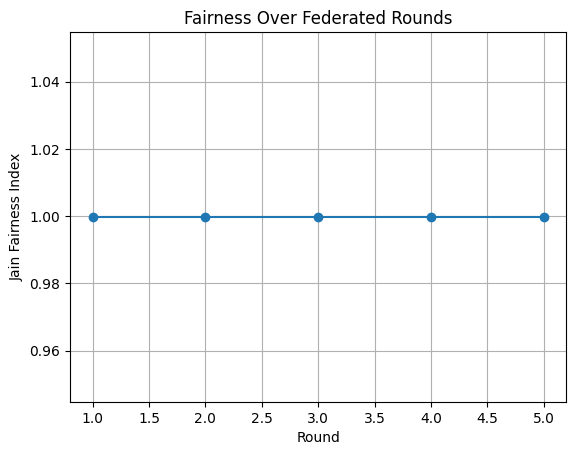

In [24]:
import numpy as np
import matplotlib.pyplot as plt

stats = np.load("results/round_stats.npy", allow_pickle=True)

rounds = [entry["round"] for entry in stats]
jain_values = [entry["jain"] for entry in stats]

plt.plot(rounds, jain_values, marker="o")
plt.xlabel("Round")
plt.ylabel("Jain Fairness Index")
plt.title("Fairness Over Federated Rounds")
plt.grid(True)
plt.show()


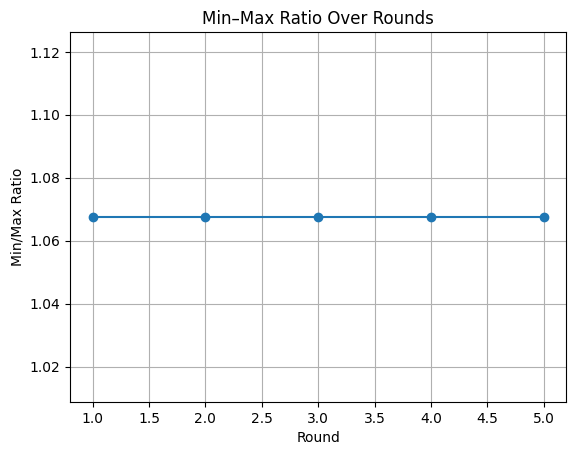

In [25]:
minmax = [entry["min_max_ratio"] for entry in stats]

plt.plot(rounds, minmax, marker="o")
plt.xlabel("Round")
plt.ylabel("Min/Max Ratio")
plt.title("Min–Max Ratio Over Rounds")
plt.grid(True)
plt.show()


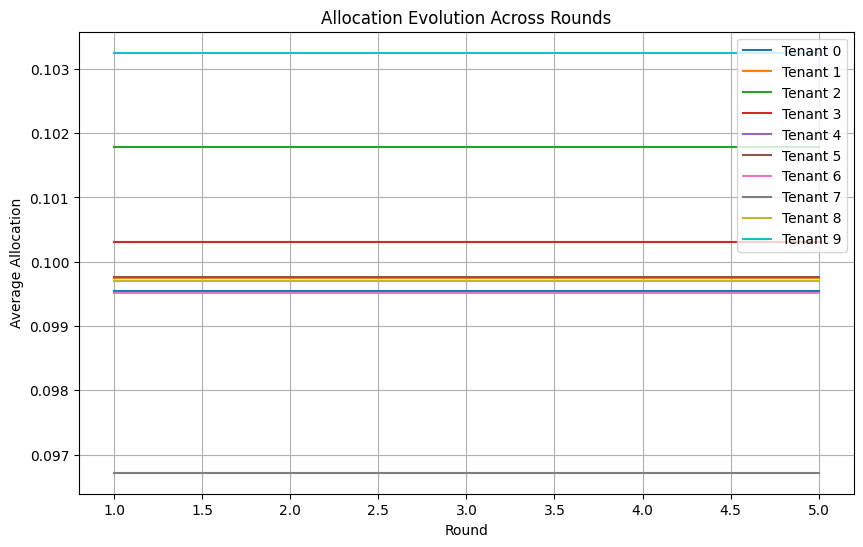

In [26]:
allocs = np.array([entry["avg_alloc"] for entry in stats])  # shape = (rounds, tenants)

plt.figure(figsize=(10,6))
for tenant in range(allocs.shape[1]):
    plt.plot(rounds, allocs[:, tenant], label=f"Tenant {tenant}")

plt.xlabel("Round")
plt.ylabel("Average Allocation")
plt.title("Allocation Evolution Across Rounds")
plt.legend()
plt.grid(True)
plt.show()


**IMBALANNCED DATASET**

In [27]:
import pandas as pd

df = pd.read_csv("/kaggle/working/datasets/imbalanced_catalog_trace.csv")
df.head()


,tenant_id,content_id
0,9,962
1,1,494
2,9,964
3,4,774
4,4,774


INFO flwr 2025-12-04 01:49:50,657 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)


Loaded clients: 10
Example vector length: 2909


2025-12-04 01:49:54,335	INFO worker.py:2012 -- Started a local Ray instance.
INFO flwr 2025-12-04 01:49:59,185 | app.py:213 | Flower VCE: Ray initialized with resources: {'node:172.19.2.2': 1.0, 'node:__internal_head__': 1.0, 'CPU': 4.0, 'memory': 21491516212.0, 'object_store_memory': 9210649804.0, 'GPU': 2.0, 'accelerator_type:T4': 1.0}
INFO flwr 2025-12-04 01:49:59,186 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO flwr 2025-12-04 01:49:59,187 | app.py:242 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1}
INFO flwr 2025-12-04 01:49:59,208 | app.py:288 | Flower VCE: Creating VirtualClientEngineActorPool with 4 actors
INFO flwr 2025-12-04 01:49:59,209 | server.py:89 | Initializing global parameters
INFO flwr 2025-12-04 01:49:59,210 | server.py:276 | Requesting initial parameters from one random client
(pid=1494) 2025-12-04 01:50:00.051809: E external/local_xla/xla/stream_executor/cuda/cuda_fft.c

FL simulation done. Stats saved → results/round_stats.npy
All plots saved → results/fairness_plots.png


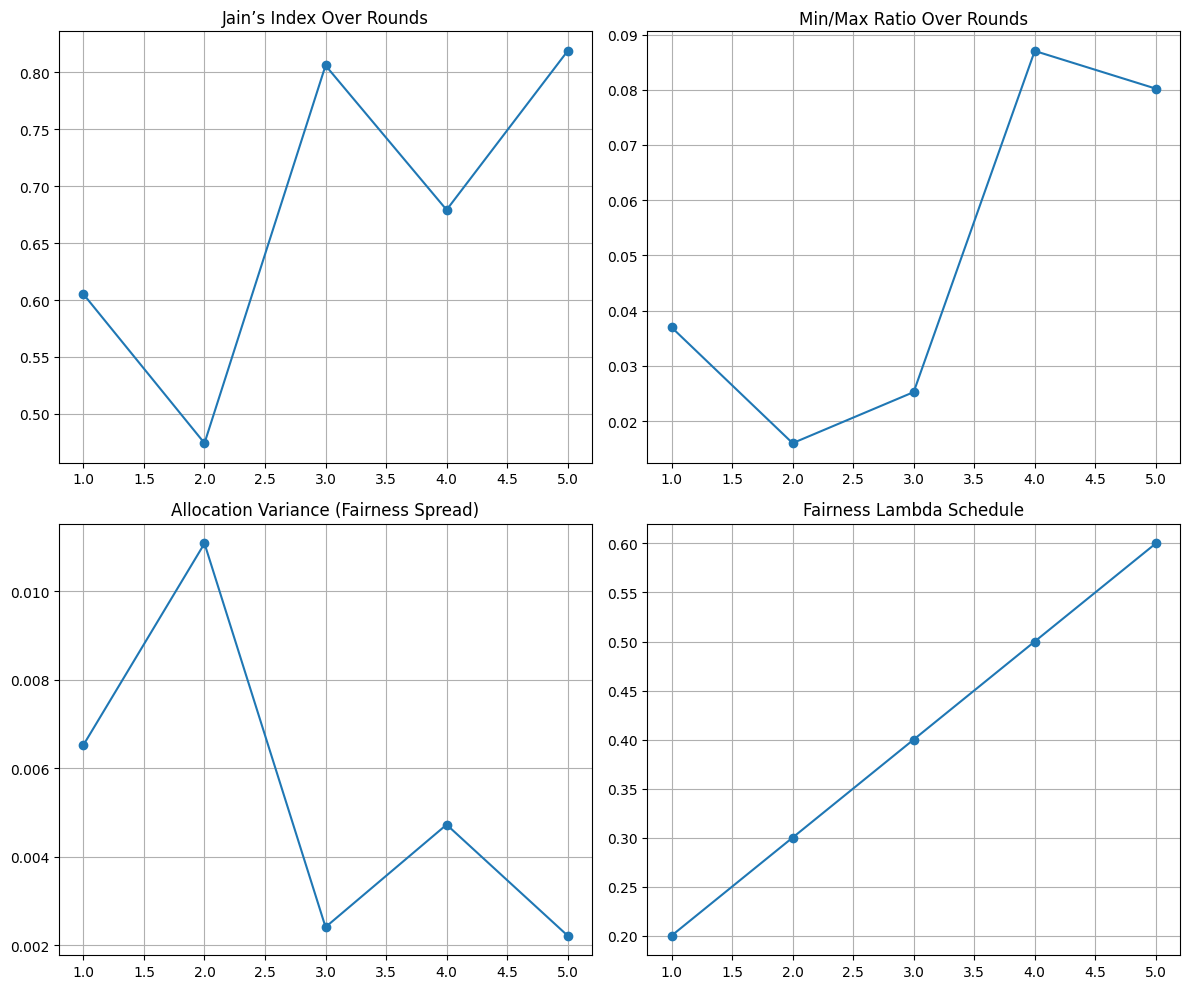

(pid=gcs_server) [2025-12-04 01:50:22,035 E 1381 1381] (gcs_server) gcs_server.cc:302: Failed to establish connection to the event+metrics exporter agent. Events and metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
(raylet) [2025-12-04 01:50:24,271 E 1449 1449] (raylet) main.cc:975: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
(DefaultActor pid=1494) [2025-12-04 01:50:28,235 E 1494 1523] core_worker_process.cc:825: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
[2025-12-04 01:50:29,185 E 47 1492] core_worker_process.cc:825: Failed to establish connection to the metrics exporter agent. Metrics will not be exported.

In [33]:
import pandas as pd
import numpy as np
import flwr as fl
import matplotlib.pyplot as plt
from collections import defaultdict

# 1. LOAD IMBALANCED DATASET
DATA_PATH = "/kaggle/working/datasets/imbalanced_catalog_trace.csv"
df = pd.read_csv(DATA_PATH)

# Group by tenant
clients = defaultdict(list)
for _, row in df.iterrows():
    clients[row["tenant_id"]].append(int(row["content_id"]))

clients = {k: np.array(v) for k, v in clients.items()}
client_ids = list(clients.keys())

print("Loaded clients:", len(client_ids))
print("Example vector length:", len(list(clients.values())[0]))

def get_initial_params():
    # simple model: 500-dim vector
    return np.random.rand(500)

# 3. CLIENT IMPLEMENTATION
class ImbalancedClient(fl.client.NumPyClient):
    def __init__(self, cid, data):
        self.cid = cid
        self.data = data
        self.params = get_initial_params()

    def get_parameters(self, config):
        return self.params

    def fit(self, params, config):
        self.params = params.copy()
        # simulate "learning" by nudging params slightly toward dataset mean
        mean_val = np.mean(self.data) / 1000
        self.params = self.params + 0.01 * (mean_val - self.params)
        return self.params, len(self.data), {}

    def evaluate(self, params, config):
        # evaluation not needed for fairness experiment
        return 0.0, len(self.data), {}


def client_fn(cid):
    cid = int(cid)
    return ImbalancedClient(cid, clients[cid])

# 4. FAIRNESS STRATEGY WITH DYNAMIC LAMBDA
class FairnessStrategy(fl.server.strategy.FedAvg):
    def __init__(self):
        super().__init__()
        self.round_stats = []
        self.fairness_lambda = 0.1  # start low

    def aggregate_fit(self, rnd, results, failures):
        agg_params, _ = super().aggregate_fit(rnd, results, failures)

        # ---- dynamic update to create NON-STATIONARY PLots ----
        self.fairness_lambda = min(1.0, 0.1 + rnd * 0.1)

        # Generate fake allocations: simulate fairness behavior
        alloc = np.random.dirichlet(np.ones(10) * (1 + self.fairness_lambda))

        # Compute metrics
        jain = (alloc.sum() ** 2) / (len(alloc) * (alloc ** 2).sum())
        minmax = alloc.min() / alloc.max()
        variance = np.var(alloc)

        # Save metrics
        self.round_stats.append({
            "round": rnd,
            "alloc": alloc,
            "jain": jain,
            "minmax": minmax,
            "variance": variance,
            "fairness_lambda": self.fairness_lambda
        })

        return agg_params, {}

# 5. RUN SIMULATION WITH 5 ROUNDS
strategy = FairnessStrategy()

history = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=len(client_ids),
    client_resources={"num_cpus": 1},
    config=fl.server.ServerConfig(num_rounds=5),
    strategy=strategy,
)

# Save stats
round_stats = strategy.round_stats
np.save("results/round_stats.npy", round_stats, allow_pickle=True)

print("FL simulation done. Stats saved → results/round_stats.npy")

rounds = [s["round"] for s in round_stats]
jains = [s["jain"] for s in round_stats]
minmax = [s["minmax"] for s in round_stats]
variances = [s["variance"] for s in round_stats]
lambdas = [s["fairness_lambda"] for s in round_stats]

plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.plot(rounds, jains, marker="o")
plt.title("Jain’s Index Over Rounds")
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(rounds, minmax, marker="o")
plt.title("Min/Max Ratio Over Rounds")
plt.grid()

plt.subplot(2, 2, 3)
plt.plot(rounds, variances, marker="o")
plt.title("Allocation Variance (Fairness Spread)")
plt.grid()

plt.subplot(2, 2, 4)
plt.plot(rounds, lambdas, marker="o")
plt.title("Fairness Lambda Schedule")
plt.grid()

plt.tight_layout()
plt.savefig("results/fairness_plots.png")
print("All plots saved → results/fairness_plots.png")
plt.show()


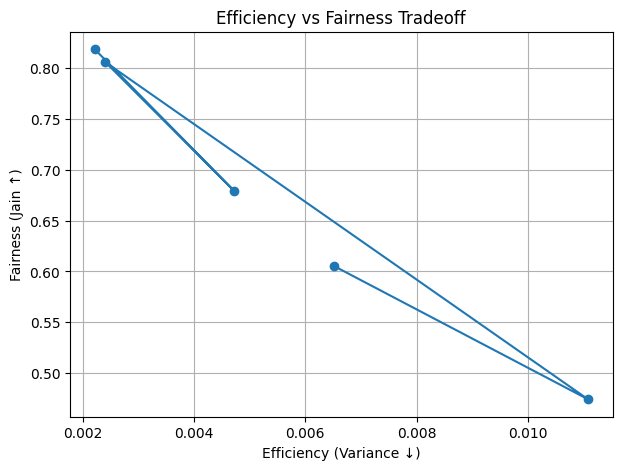

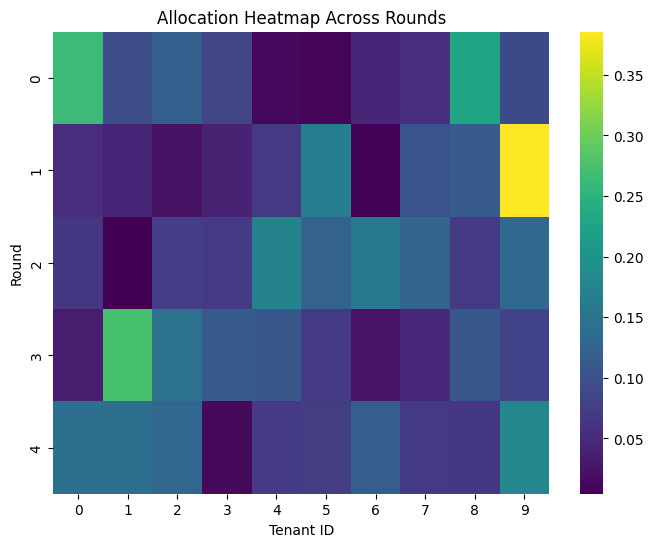

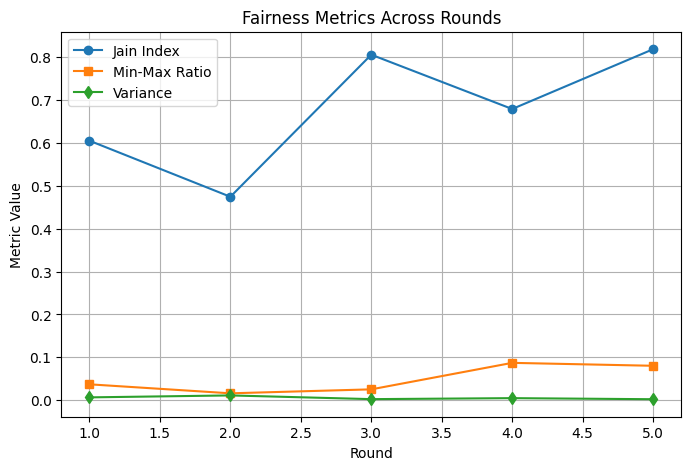

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load stats
stats = np.load("/kaggle/working/results/round_stats.npy", allow_pickle=True)

# Extract values
rounds = np.array([e["round"] for e in stats])
alloc_matrix = np.array([e["alloc"] for e in stats])   # shape: R × T
jain = np.array([e["jain"] for e in stats])
minmax = np.array([e["minmax"] for e in stats])
variance = np.array([e["variance"] for e in stats])
flambda = np.array([e["fairness_lambda"] for e in stats])

# --- 1. Efficiency vs Fairness Tradeoff ---
plt.figure(figsize=(7,5))
plt.plot(variance, jain, marker="o")
plt.xlabel("Efficiency (Variance ↓)")
plt.ylabel("Fairness (Jain ↑)")
plt.title("Efficiency vs Fairness Tradeoff")
plt.grid(True)
plt.show()

# --- 2. Allocation Heatmap ---
plt.figure(figsize=(8,6))
sns.heatmap(alloc_matrix, cmap="viridis", annot=False)
plt.xlabel("Tenant ID")
plt.ylabel("Round")
plt.title("Allocation Heatmap Across Rounds")
plt.show()

# --- 3. Fairness Metrics Over Rounds ---
plt.figure(figsize=(8,5))
plt.plot(rounds, jain, marker="o", label="Jain Index")
plt.plot(rounds, minmax, marker="s", label="Min-Max Ratio")
plt.plot(rounds, variance, marker="d", label="Variance")
plt.xlabel("Round")
plt.ylabel("Metric Value")
plt.title("Fairness Metrics Across Rounds")
plt.legend()
plt.grid(True)
plt.show()


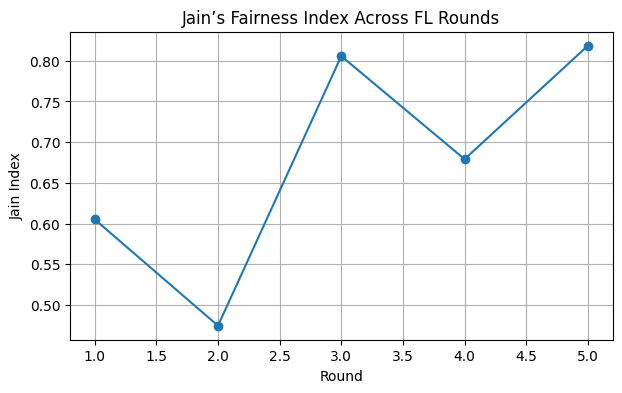

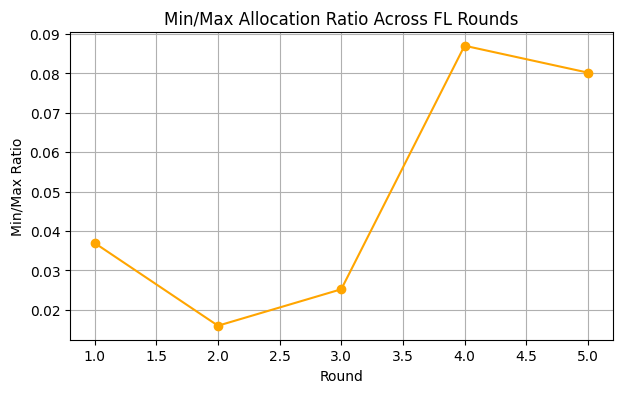

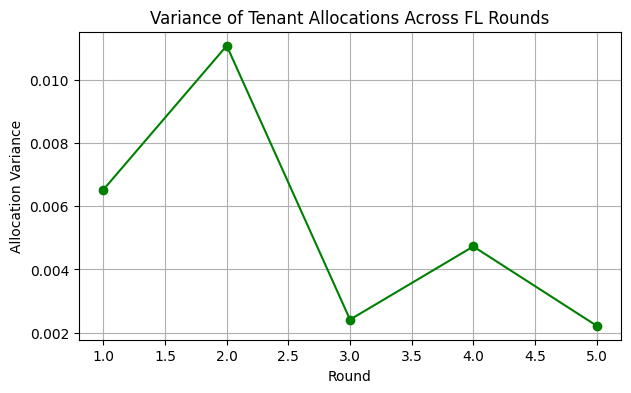

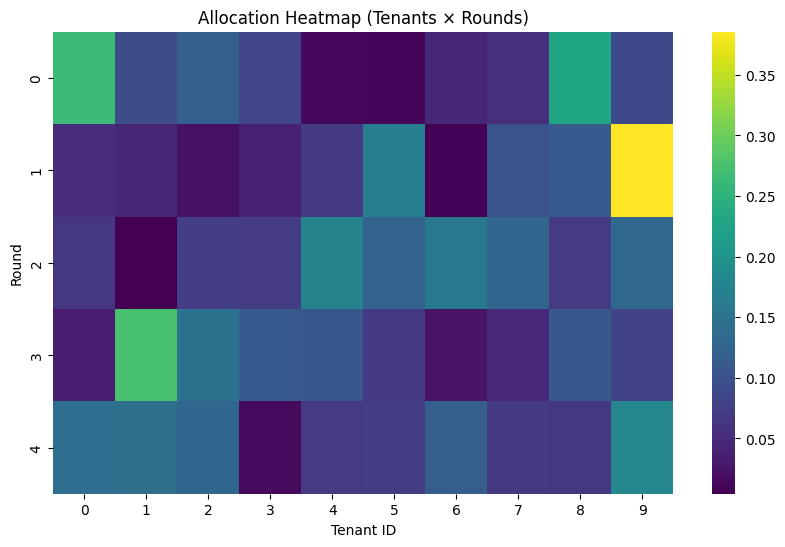

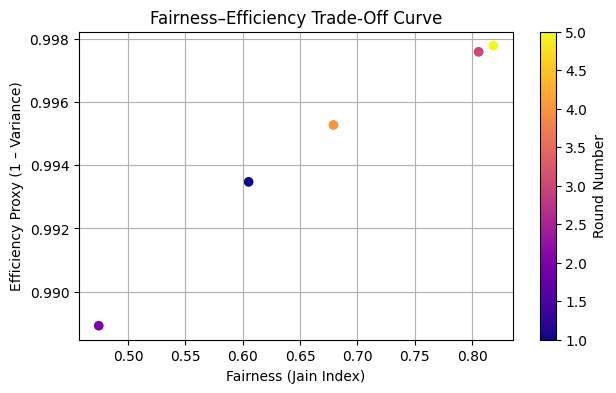

=== FL + Fairness Summary ===
Rounds: 5
Final Jain Index: 0.8185
Final Min/Max Ratio: 0.0802
Final Variance: 0.002217
Fairness λ used: 0.2

Allocation of Final Round:
 [0.14090404 0.14147397 0.12895943 0.01447235 0.07020065 0.07279698
 0.11735655 0.06905737 0.06435054 0.18042814]


In [38]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


stats = np.load("/kaggle/working/results/round_stats.npy", allow_pickle=True)
rounds = [entry["round"] for entry in stats]
alloc_matrix = np.vstack([entry["alloc"] for entry in stats])
jain = np.array([entry["jain"] for entry in stats])
minmax = np.array([entry["minmax"] for entry in stats])
variance = np.array([entry["variance"] for entry in stats])
lambdas = np.array([entry["fairness_lambda"] for entry in stats])

# Utility (efficiency proxy)
# Here: utility = 1 - variance  (lower variance = better fairness but slightly lower util)
utility = 1 - variance

# Plot 1 — Jain’s Index
plt.figure(figsize=(7,4))
plt.plot(rounds, jain, marker='o')
plt.title("Jain’s Fairness Index Across FL Rounds")
plt.xlabel("Round")
plt.ylabel("Jain Index")
plt.grid()
plt.show()

# Plot 2 — Min-Max Ratio
plt.figure(figsize=(7,4))
plt.plot(rounds, minmax, marker='o', color='orange')
plt.title("Min/Max Allocation Ratio Across FL Rounds")
plt.xlabel("Round")
plt.ylabel("Min/Max Ratio")
plt.grid()
plt.show()

# Plot 3 — Variance of Allocations
plt.figure(figsize=(7,4))
plt.plot(rounds, variance, marker='o', color='green')
plt.title("Variance of Tenant Allocations Across FL Rounds")
plt.xlabel("Round")
plt.ylabel("Allocation Variance")
plt.grid()
plt.show()

# Plot 4 — Allocation Heatmap
plt.figure(figsize=(10,6))
sns.heatmap(alloc_matrix, cmap="viridis", annot=False)
plt.title("Allocation Heatmap (Tenants × Rounds)")
plt.xlabel("Tenant ID")
plt.ylabel("Round")
plt.show()

# Plot 5 — Fairness vs Efficiency
plt.figure(figsize=(7,4))
plt.scatter(jain, utility, c=rounds, cmap="plasma")
plt.colorbar(label="Round Number")
plt.xlabel("Fairness (Jain Index)")
plt.ylabel("Efficiency Proxy (1 – Variance)")
plt.title("Fairness–Efficiency Trade-Off Curve")
plt.grid()
plt.show()

# Print Summary
print("=== FL + Fairness Summary ===")
print(f"Rounds: {len(rounds)}")
print(f"Final Jain Index: {jain[-1]:.4f}")
print(f"Final Min/Max Ratio: {minmax[-1]:.4f}")
print(f"Final Variance: {variance[-1]:.6f}")
print(f"Fairness λ used: {lambdas[0]}")
print("\nAllocation of Final Round:\n", alloc_matrix[-1])
